In [155]:
import sys
import os 
import time
import requests
import json
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 20)})
from bs4 import BeautifulSoup
from ipywidgets import interact

In [124]:
def get_historical_rankings(date):
    url = 'https://coinmarketcap.com/historical/{}'.format(date.strftime('%Y%m%d'))
    response = requests.get(url).text
    soup = BeautifulSoup(response)
    table_head = soup.select('thead')[0]
    table_body = soup.select('tbody')[0]
    table_cols = [col.text for col in table_head.find_all('th')]
    table_data = [[data.text.strip() for data in row.find_all('td')] for row in table_body.find_all('tr')]
    rankings = pd.DataFrame(table_data, columns=table_cols)
    rankings['date'] = date
    return rankings

In [126]:
rankings_df = pd.DataFrame()
for date in pd.DatetimeIndex(start=dt(2013, 6, 1), end=dt(2019,1,1), freq='1M'):
    rankings_df = rankings_df.append(get_historical_rankings(date), ignore_index=True)
rankings_df['ranking'] = rankings_df['#'].astype(int)

In [200]:
get_rankings = lambda symbol: rankings_df[rankings_df.Symbol==symbol][['ranking','date']].set_index('date')

def plot_rank_over_time(symbol):
    s = get_rankings(symbol)
    s.plot()
    s.hist()
    

interact(plot_rank_over_time, symbol=rankings_df.groupby('Symbol').ranking.mean().sort_values().index)


interactive(children=(Dropdown(description='symbol', options=('BTC', 'ETH', 'XRP', 'LTC', 'ADA', 'DASH', 'BSV'…

<function __main__.plot_rank_over_time(symbol)>

In [156]:
def get_assets_within_ranking(ranking_threshold):
    symbols = rankings_df[rankings_df.ranking<=ranking_threshold].Symbol.unique()
    rankings_df[rankings_df.Symbol.isin(symbols)].set_index('date').groupby('Symbol').ranking.plot(logy=True)
    plt.axhline(ranking_threshold, color='grey', ls='dashed')
    plt.legend()
interact(get_assets_within_ranking, ranking_threshold=5)

interactive(children=(IntSlider(value=5, description='ranking_threshold', max=15, min=-5), Output()), _dom_cla…

<function __main__.get_assets_within_ranking(ranking_threshold)>

In [1]:
important_tokens = rankings_df[rankings_df.ranking<=10].groupby('Symbol')['date'].first().to_frame().reset_index()
important_tokens['avg_rank'] = important_tokens.Symbol.apply(lambda s: get_rankings(s).mean())
important_tokens[important_tokens.avg_rank<25].sort_values(['date','avg_rank']).reset_index(drop=True)





NameError: name 'rankings_df' is not defined

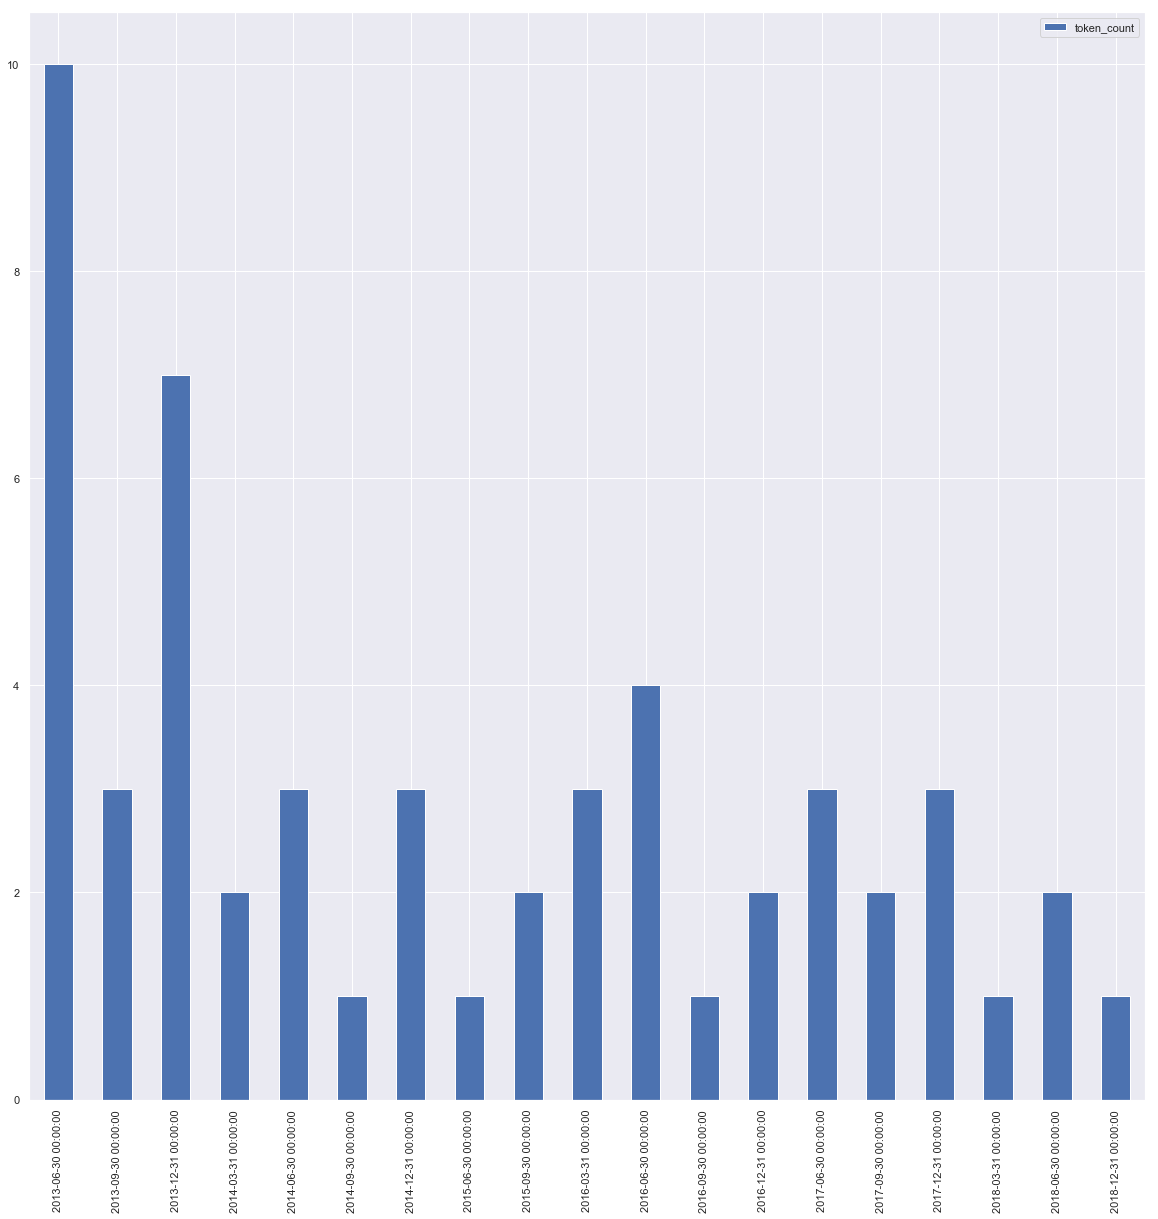

In [209]:
grouped = important_tokens.set_index('date').groupby(pd.Grouper(freq='1Q'))
years = pd.DataFrame(index=grouped.indices.keys())
years['token_count'] = grouped.Symbol.count()
#years['first_token'] = grouped.first()
years.plot(kind='bar')



In [188]:
grouped.indices.keys()

dict_keys([Timestamp('2013-12-31 00:00:00', freq='A-DEC'), Timestamp('2014-12-31 00:00:00', freq='A-DEC'), Timestamp('2015-12-31 00:00:00', freq='A-DEC'), Timestamp('2016-12-31 00:00:00', freq='A-DEC'), Timestamp('2017-12-31 00:00:00', freq='A-DEC'), Timestamp('2018-12-31 00:00:00', freq='A-DEC'), 0, 1])

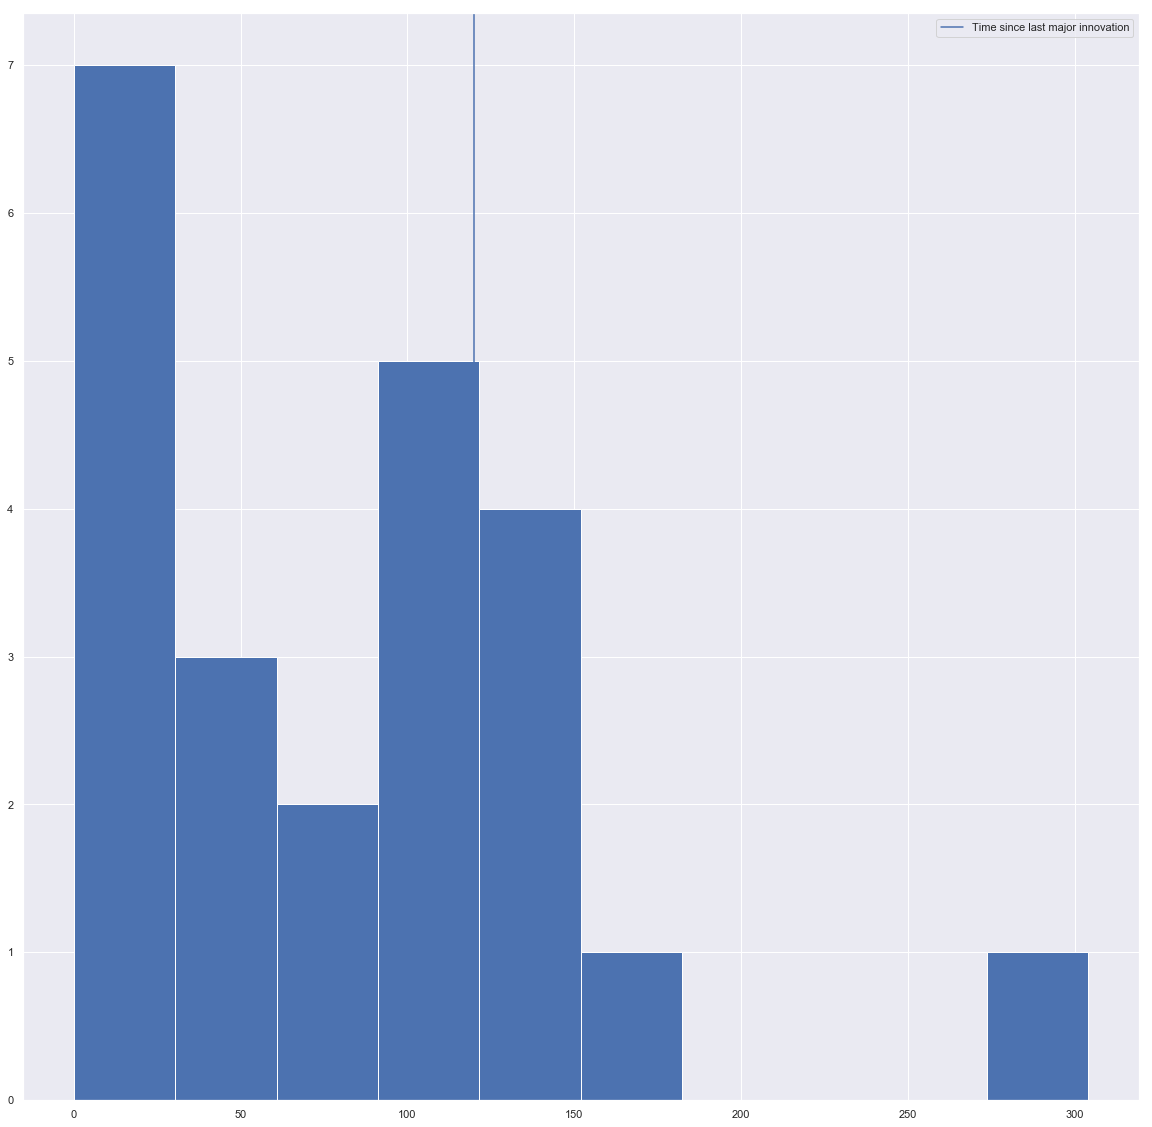

In [170]:
innovation_rate = important_tokens.date.diff().dt.days
innovation_rate.hist()
plt.axvline(innovation_rate.iloc[-1], label='Time since last major innovation')
plt.legend()


In [165]:
rankings_df.to_csv('historical_rankings.csv')

In [172]:
innovation_rate.describe()

count     23.000000
mean      76.739130
std       72.676254
min        0.000000
25%       29.000000
50%       62.000000
75%      121.000000
max      304.000000
Name: date, dtype: float64